#### Import Package Dependencies and Dataset

In [1]:
import os, sys, re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
import warnings
warnings.filterwarnings('ignore')
# display options
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)

In [2]:
dataset = pd.read_csv('dataset_olist_merged.csv')
dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_state,geolocation_city,customer_geolocation_lat,customer_geolocation_lng,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio be...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,SP,sao paulo,-23.576983,-46.587161,9350,maua,SP,-23.680729,-46.444238,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio be...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,SP,sao paulo,-23.576983,-46.587161,9350,maua,SP,-23.680729,-46.444238,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio be...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,SP,sao paulo,-23.576983,-46.587161,9350,maua,SP,-23.680729,-46.444238,housewares
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,BA,barreiras,-12.177924,-44.660711,31570,belo horizonte,SP,-19.807681,-43.980427,perfumery
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,GO,vianopolis,-16.745150,-48.514783,14840,guariba,SP,-21.363502,-48.229601,auto


In [4]:
# Euclidean distances between seller and customer
dataset['euclidean_distance'] = (np.sqrt(((dataset['customer_geolocation_lat'] - dataset['seller_geolocation_lat']) ** 2) +
                                          ((dataset['customer_geolocation_lng'] - dataset['seller_geolocation_lng']) ** 2)))

#### Train-test split

In [5]:
from sklearn.model_selection import train_test_split

# work with indexes
index_train, index_test = train_test_split(dataset.index, train_size = 0.7, random_state = 42)

# write training and test sets
# copy() does not make a difference here but it's better to be explicit
df_train = dataset.loc[index_train, :].copy()
df_test = dataset.loc[index_test, :].copy()

In [6]:
print("Variables in the training set:")
print(df_train.columns.to_list())
print("Variables in the test set:")
print(df_test.columns.to_list())

Variables in the training set:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'geolocation_state', 'geolocation_city', 'customer_geolocation_lat', 'customer_geolocation_lng', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'seller_geolocation_lat', 'seller_geolocation_lng', 'pr

#### Define Target Variable (for classification):

* look at the distribution of response variable `y`

In [7]:
df_train['review_score'] = df_train['review_score'].apply(lambda x: 1 if x > 3 else 0)
df_test['review_score'] = df_test['review_score'].apply(lambda x: 1 if x > 3 else 0)

In [8]:
df_train['review_score'].value_counts().reset_index()

,review_score,count
0,1,64598
1,0,21507


In [9]:
y_train = df_train['review_score'].to_numpy()
y_test = df_test['review_score'].to_numpy()

In [10]:
print(df_train.shape)
print(df_test.shape)
print(y_train.shape)
print(y_test.shape)

(86105, 47)
(36903, 47)
(86105,)
(36903,)


#### Initial Table Inspection

In [11]:
df_train.isnull().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date       883
order_delivered_customer_date     1836
order_estimated_delivery_date        0
payment_sequential                   2
payment_type                         2
payment_installments                 2
payment_value                        2
review_id                          689
review_score                         0
review_comment_title             75878
review_comment_message           49934
review_creation_date               689
review_answer_timestamp            689
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date      

#### Detect Data Types of Variables (Features)

In [12]:
from dabl import detect_types # useful for data exploration, from tutorial

detected = detect_types(df_train)
detected

,continuous,dirty_float,low_card_int_ordinal,low_card_int_categorical,categorical,date,free_string,useless
order_id,False,False,False,False,False,False,True,False
customer_id,False,False,False,False,False,False,True,False
order_status,False,False,False,False,False,False,False,True
order_purchase_timestamp,False,False,False,False,False,True,False,False
order_approved_at,False,False,False,False,False,True,False,False
order_delivered_carrier_date,False,False,False,False,False,True,False,False
order_delivered_customer_date,False,False,False,False,False,True,False,False
order_estimated_delivery_date,False,False,False,False,False,True,False,False
payment_sequential,False,False,False,False,False,False,False,True
payment_type,False,False,False,False,True,False,False,False


In [13]:
#### 自行判断是否真的是useless features，并且手动筛选被判断成其他datatype的columns中有哪些是用不上的
useless_features = detected[detected['useless'] == True].index.to_list()
useless_features

['order_status', 'payment_sequential']

In [14]:
df_train['order_status'].value_counts().reset_index()

# df = df[df['order_status'] == 'delivered'].copy()

,order_status,count
0,delivered,84268
1,shipped,896
2,canceled,410
3,processing,263
4,invoiced,261
5,unavailable,4
6,approved,3


In [15]:
df_train['payment_sequential'].value_counts().reset_index().head(5)

,payment_sequential,count
0,1.0,82374
1,2.0,2480
2,3.0,478
3,4.0,237
4,5.0,140


In [17]:
df_train['payment_sequential'].value_counts().reset_index().head(5)

,payment_sequential,count
0,1.0,82374
1,2.0,2480
2,3.0,478
3,4.0,237
4,5.0,140


In [18]:
detected.columns

Index(['continuous', 'dirty_float', 'low_card_int_ordinal',
       'low_card_int_categorical', 'categorical', 'date', 'free_string',
       'useless'],
      dtype='object')

In [19]:
### continuous variables
print("Continuous variables:\n", detected[detected['continuous'] == True].index)

### float
print("Float variables: \n", detected[detected['dirty_float'] == True].index)

### low_card_int_ordinal
print("low_card_int_ordinal variables: \n", detected[detected['low_card_int_ordinal'] == True].index)

### categorical
print("Categorical variables: \n", detected[detected['categorical'] == True].index)

### date
print("Datetime variables: \n", detected[detected['date'] == True].index)

### free_string
print("String variables: \n", detected[detected['free_string'] == True].index)

Continuous variables:
 Index(['payment_installments', 'payment_value', 'customer_zip_code_prefix',
       'price', 'freight_value', 'product_description_lenght',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'customer_geolocation_lat',
       'customer_geolocation_lng', 'seller_zip_code_prefix',
       'seller_geolocation_lat', 'seller_geolocation_lng',
       'euclidean_distance'],
      dtype='object')
Float variables: 
 Index([], dtype='object')
low_card_int_ordinal variables: 
 Index(['product_name_lenght', 'product_photos_qty'], dtype='object')
Categorical variables: 
 Index(['payment_type', 'review_score', 'customer_state',
       'product_category_name', 'geolocation_state', 'seller_city',
       'seller_state', 'product_category_name_english'],
      dtype='object')
Datetime variables: 
 Index(['order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_e

In [21]:
### define new feature based on existing feature
df_train['price_category'] = df_train['price'].apply(
    lambda x: 'expensive' if x >= 139 else ('affordable' if x >= 40 and x < 139 else 'cheap'))
df_test['price_category'] = df_test['price'].apply(
    lambda x: 'expensive' if x >= 139 else ('affordable' if x >= 40 and x < 139 else 'cheap'))

#### Date Time Variables

In [44]:
lst_datetime = detected[detected['date'] == True].index.to_list()

for timestamp in lst_datetime:
    df[timestamp] = pd.to_datetime(df[timestamp])

df['approving_time'] = df[['order_purchase_timestamp','order_approved_at']].apply(
    lambda row : str(row['order_approved_at'] - row['order_purchase_timestamp']).split(' ')[0], axis=1
)
df['processing_time'] = df[['order_approved_at','order_delivered_carrier_date']].apply(
    lambda row : str(row['order_delivered_carrier_date'] - row['order_approved_at']).split(' ')[0], axis=1
)
df['delivery_time'] = df[['order_delivered_carrier_date','order_delivered_customer_date']].apply(
    lambda row : str(row['order_delivered_customer_date'] - row['order_delivered_carrier_date']).split(' ')[0], axis=1
)
df['delivered_on_time'] = df[['order_delivered_customer_date','order_estimated_delivery_date']].apply(
    lambda row : 1 if row['order_delivered_customer_date'] <= row['order_estimated_delivery_date'] else 0, axis=1
)

df['delivered_late'] = df[['order_delivered_customer_date','order_estimated_delivery_date']].apply(
    lambda row : 0 if row['order_delivered_customer_date'] <= row['order_estimated_delivery_date'] else 1, axis=1
)

df['seller_on_time'] = df[['order_delivered_carrier_date','shipping_limit_date']].apply(
    lambda row : 1 if row['order_delivered_carrier_date'] <= row['shipping_limit_date'] else 0, axis=1
)

df['order_completion_time'] = df[['order_delivered_customer_date','order_purchase_timestamp']].apply(
    lambda row : str(row['order_delivered_customer_date'] - row['order_purchase_timestamp']).split(' ')[0], axis=1
)


df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_state,geolocation_city,customer_geolocation_lat,customer_geolocation_lng,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng,product_category_name_english,approving_time,processing_time,delivery_time,delivered_on_time,delivered_late,seller_on_time,euclidean_distance,order_completion_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio be...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,SP,sao paulo,-23.576983,-46.587161,9350,maua,SP,-23.680729,-46.444238,housewares,0,2,6,1,0,1,0.176608,8
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio be...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,SP,sao paulo,-23.576983,-46.587161,9350,maua,SP,-23.680729,-46.444238,housewares,0,2,6,1,0,1,0.176608,8
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio be...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,SP,sao paulo,-23.576983,-46.587161,9350,maua,SP,-23.680729,-46.444238,housewares,0,2,6,1,0,1,0.176608,8
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,BA,barreiras,-12.177924,-44.660711,31570,belo horizonte,SP,-19.807681,-43.980427,perfumery,1,0,12,1,0,1,7.660024,13
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4

In [17]:
df[df['order_status']=='delivered']['delivered_late'].value_counts().reset_index()

,delivered_late,count
0,0,110899
1,1,9480


In [18]:
df[['delivered_on_time','delivered_late']].value_counts().reset_index()

,delivered_on_time,delivered_late,count
0,1,0,110906
1,0,1,12102


In [19]:
df[df['approving_time'] != 'NaT']
# df = df[df['processing_time'] != 'NaT']
# df = df[df['delivery_time'] != 'NaT']
df['delivered_on_time'].value_counts().reset_index()

,delivered_on_time,count
0,1,110906
1,0,12102


In [20]:
df['delivered_on_time'].value_counts().reset_index()

,delivered_on_time,count
0,1,110906
1,0,12102


In [49]:
lst_duration = ['approving_time','processing_time','delivery_time','delivered_on_time','delivered_late','seller_on_time','order_completion_time']

In [50]:
df[lst_duration].dtypes

approving_time           object
processing_time          object
delivery_time            object
delivered_on_time         int64
delivered_late            int64
seller_on_time            int64
order_completion_time    object
dtype: object

#### Continuous Variables

In [46]:
lst_continuous = detected[detected['continuous'] == True].index.to_list()

df[lst_continuous]

,payment_installments,payment_value,review_score,customer_zip_code_prefix,price,freight_value,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_geolocation_lat,customer_geolocation_lng,seller_zip_code_prefix,seller_geolocation_lat,seller_geolocation_lng,euclidean_distance
0,1.0,18.12,4.0,3149,29.99,8.72,268.0,500.0,19.0,8.0,13.0,-23.576983,-46.587161,9350,-23.680729,-46.444238,0.176608
1,1.0,2.00,4.0,3149,29.99,8.72,268.0,500.0,19.0,8.0,13.0,-23.576983,-46.587161,9350,-23.680729,-46.444238,0.176608
2,1.0,18.59,4.0,3149,29.99,8.72,268.0,500.0,19.0,8.0,13.0,-23.576983,-46.587161,9350,-23.680729,-46.444238,0.176608
3,1.0,141.46,4.0,47813,118.70,22.76,178.0,400.0,19.0,13.0,19.0,-12.177924,-44.660711,31570,-19.807681,-43.980427,7.660024
4,3.0,179.12,5.0,75265,159.90,19.22,232.0,420.0,24.0,19.0,21.0,-16.745150,-48.514783,14840,-21.363502,-48.229601,4.627149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123003,4.0,441.16,2.0,28685,179.99,40.59,1893.0,6550.0,20.0,20.0,20.0,-22.562789,-42.694844,37175,-20.940578,-45.827237,3.527529
123004,4.0,441.16,2.0,28685,179.99,40.59,1893.0,6550.0,20.0,20.0,20.0,-22.563113,-42.692414,37175,-20.940578,-45.827237,3.529836
123005,4.0,441.16,2.0,28685,179.99,40.59,1893.0,6550.0,20.0,20.0,20.0,-22.562789,-42.694844,37175,-20.940578,-45.827237,3.527529
123006,1.0,86.86,5.0,83750,68.50,18.36,569.0,150.0,16.0,7.0,15.0,-25.764308,-49.720376,14407,-20.496232,-47.418448,5.749043


In [47]:
df[lst_continuous].dtypes

payment_installments          float64
payment_value                 float64
review_score                  float64
customer_zip_code_prefix        int64
price                         float64
freight_value                 float64
product_description_lenght    float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
customer_geolocation_lat      float64
customer_geolocation_lng      float64
seller_zip_code_prefix          int64
seller_geolocation_lat        float64
seller_geolocation_lng        float64
euclidean_distance            float64
dtype: object

In [24]:
#### 并不是所有的都是有意义的numerical variables 我们需要通过business判断来看那些是真的numerical 可以用作model prediction的features
lst_numerical = ['payment_value','review_score','price','freight_value','product_weight_g',
                 'product_length_cm','product_height_cm','product_width_cm']

lst_continuous_others = list(set(lst_continuous) - set(lst_numerical))

print(lst_numerical)
print(lst_continuous_others)

['payment_value', 'review_score', 'price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
['seller_geolocation_lng', 'seller_zip_code_prefix', 'customer_geolocation_lng', 'payment_installments', 'customer_zip_code_prefix', 'customer_geolocation_lat', 'product_description_lenght', 'seller_geolocation_lat']


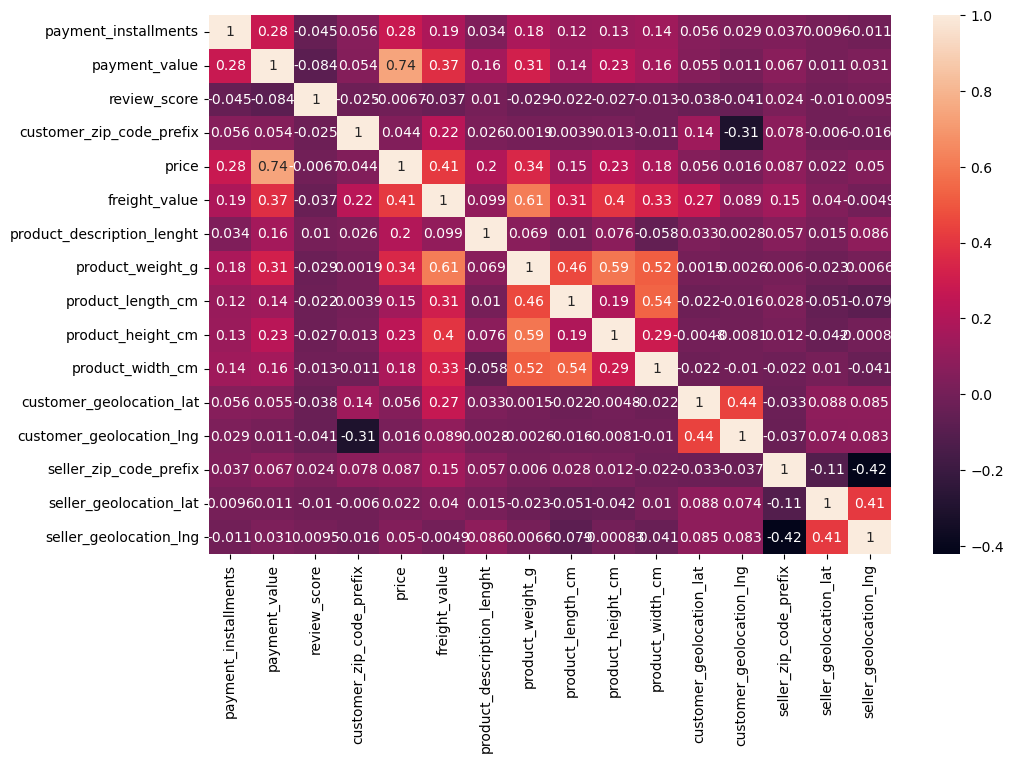

In [25]:
corr = df[lst_continuous].corr()

plt.figure(figsize=(11, 7))  # Width, Height in inches
sns.heatmap(corr, annot=True, fmt='.2g')
plt.show()

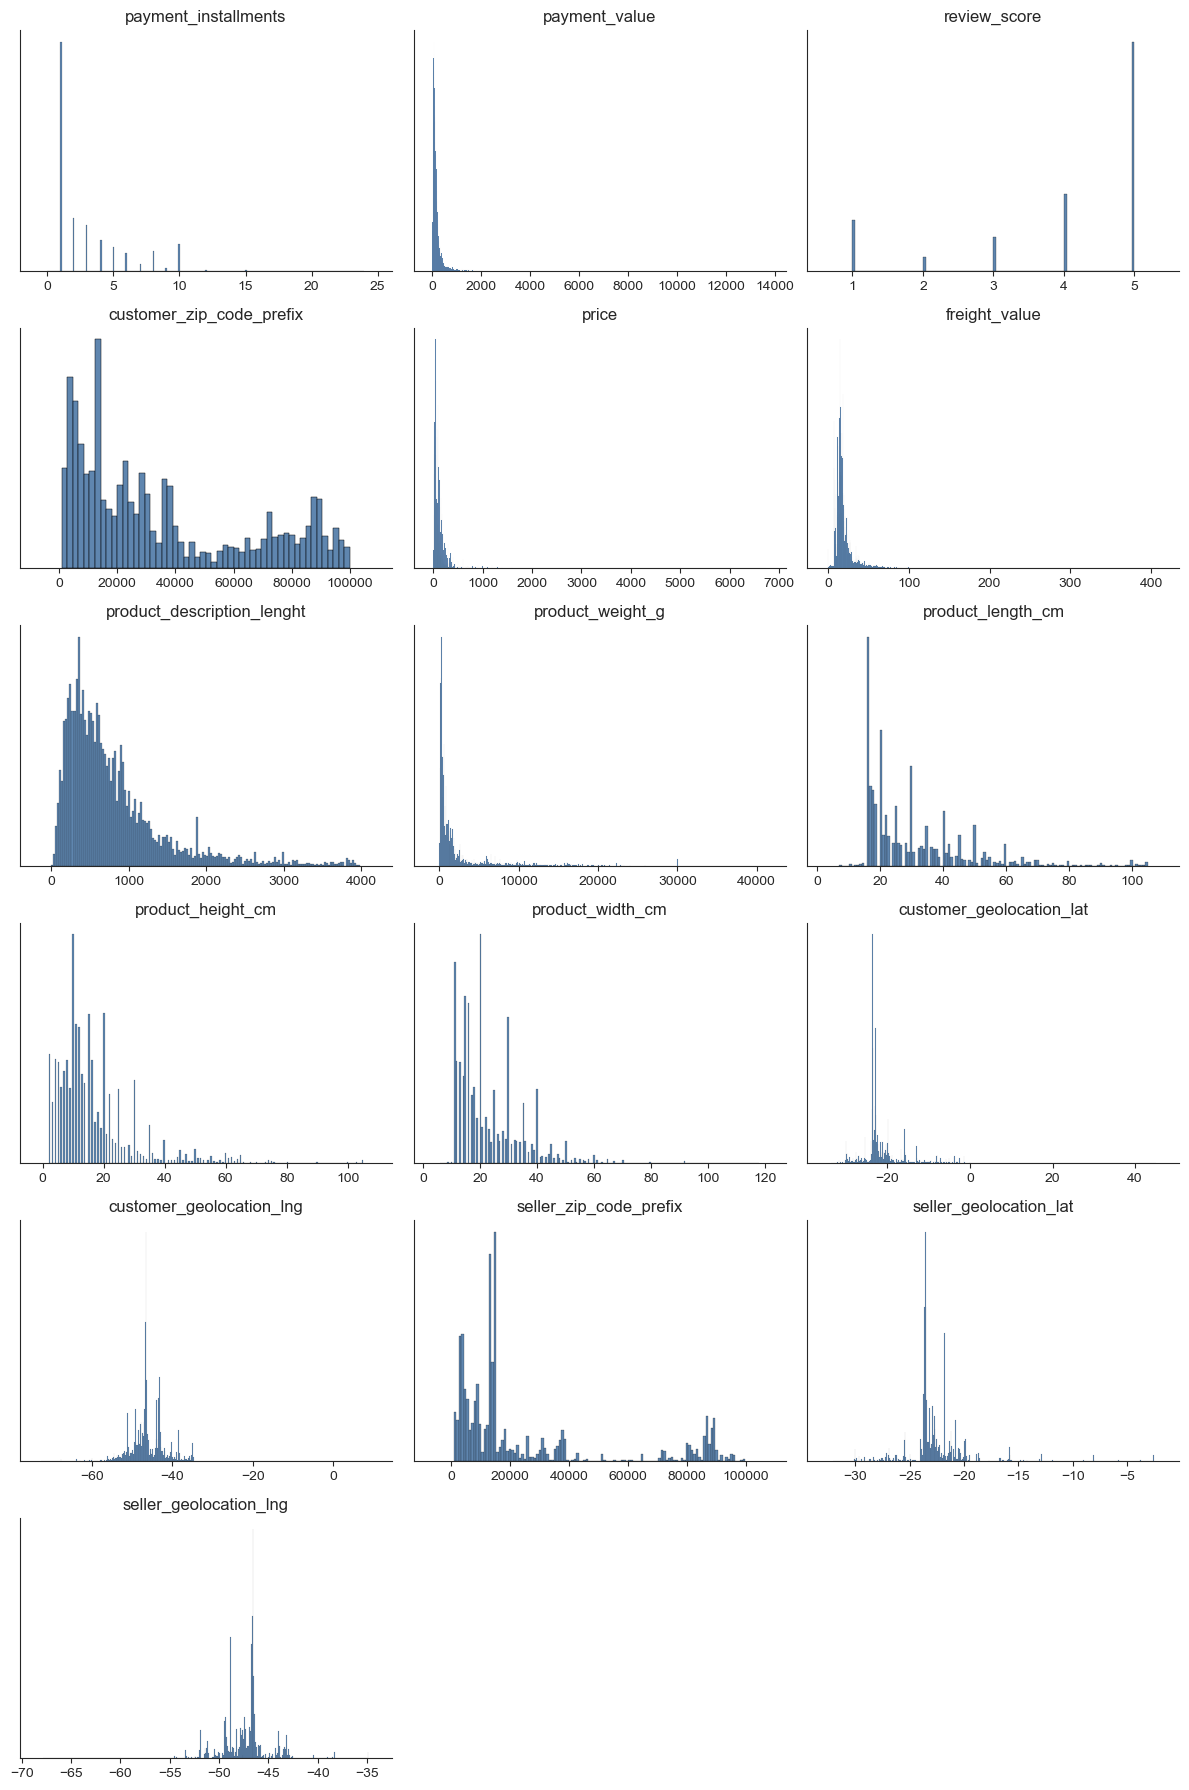

In [26]:
from tutorial4 import distplots, crosstabplots
distplots(df[lst_continuous])
plt.show()

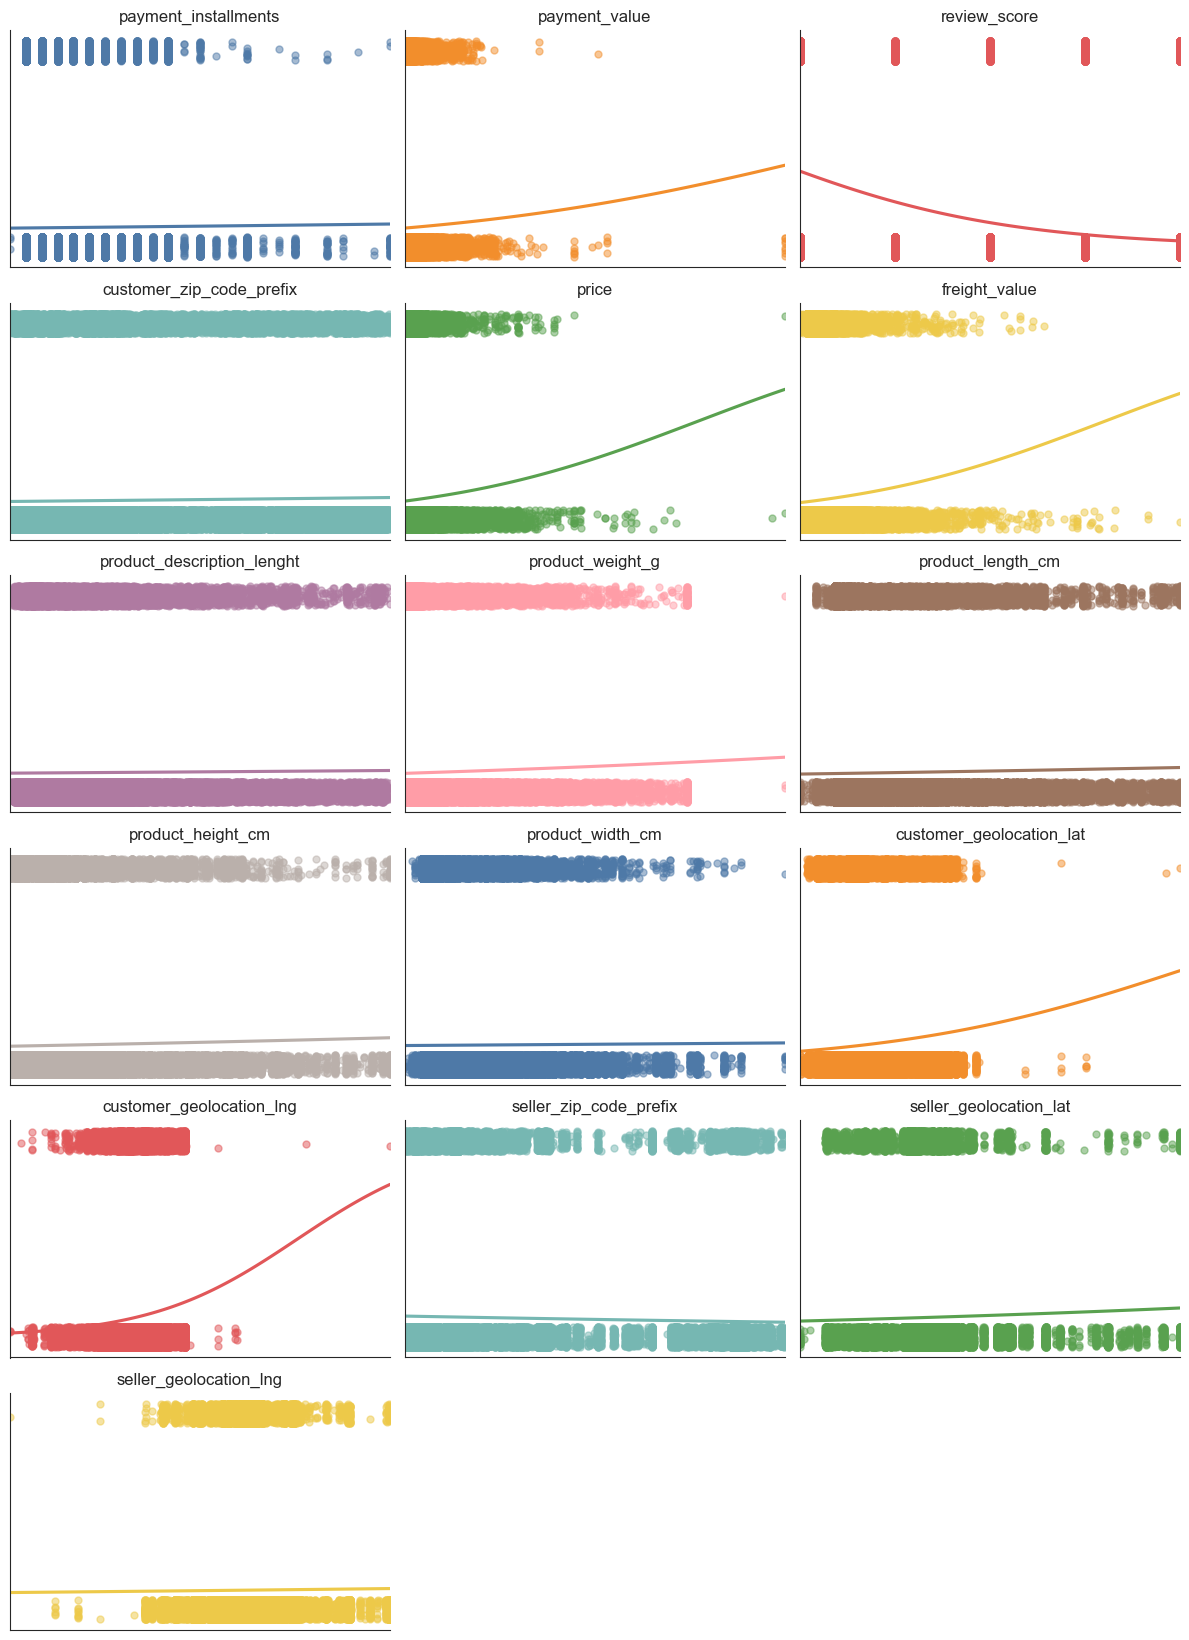

In [27]:
from tutorial4 import regplots

fig, ax = regplots(df[lst_continuous], df['delivered_late'])
plt.show()

#### Categorical Variables

In [69]:
lst_categorical = detected[detected['categorical'] == True].index.to_list()

df[lst_categorical]

,payment_type,review_creation_date,customer_state,product_category_name,geolocation_state,seller_city,seller_state,product_category_name_english
0,credit_card,2017-10-11,SP,utilidades_domesticas,SP,maua,SP,housewares
1,voucher,2017-10-11,SP,utilidades_domesticas,SP,maua,SP,housewares
2,voucher,2017-10-11,SP,utilidades_domesticas,SP,maua,SP,housewares
3,boleto,2018-08-08,BA,perfumaria,BA,belo horizonte,SP,perfumery
4,credit_card,2018-08-18,GO,automotivo,GO,guariba,SP,auto
...,...,...,...,...,...,...,...,...
123003,credit_card,2018-01-26 00:00:00,RJ,informatica_acessorios,RJ,ilicinea,MG,computers_accessories
123004,credit_card,2018-01-26 00:00:00,RJ,informatica_acessorios,RJ,ilicinea,MG,computers_accessories
123005,credit_card,2018-01-26 00:00:00,RJ,informatica_acessorios,RJ,ilicinea,MG,computers_accessories
123006,debit_card,2018-03-17 00:00:00,PR,beleza_saude,PR,franca,SP,health_beauty
